#### Creating the HDF5 Dataset

* Objective is to transform from a **Hierarchical version** (folders and files) of a dataset to a more **compact** representation
![HDF5 Compact Dataset](../../images/hdf5_dataset.png)

* This involves putting all the images in a Zip file as numpy array along with their string and binary labels
* We will also divide the dataset into 3 sections i.e. training (train), validation (dev) and testing (test)
* We will also add a csv file containing all the information about the images i.e. image name, class, width, height and size to allow us to make statistics about the images

##### Steps

1. Compress all images into one HDF5 dataset file
2. Split the dataset into train/dev/test datasets

#### Why HDF5 representation?

* More compact representation of the dataset - only one file containing all images in a numpy array format
* Much faster to load (in Google Colab)
* Fixed partition into train, dev/test datasets 
* Make possible to compare between models - since we are using the same training, testing and validation data. This will allow for a fair comparison of the performance of the different deep learning models

#### Converting dataset into HDF5

In [1]:
# required modules
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf


#### Decide the image size

* 224 is used in common deep neural network models, but we can choose any other size.
* Large image sizes would require more memory for the deep learning model and it will take longer to execute
* Smaller image sizes will lead to faster execution however we would loose a lot of features

In [2]:
IMAGE_SIZE = 224

#### Specify the path for the location of the dataset

In [3]:
#Change the paths below according to the system on which the code is being run
# good to have the size in the name in case you create datasets with different image sizes.
DATASET_PATH = '../../dataset'
H5DATASET_FOLDER = '../../h5-dataset' #created at run time
TARGET_HDF5_DATASET_PATH =f'{H5DATASET_FOLDER}/Vehicle-type-dataset-SIZE{IMAGE_SIZE}.hdf5' #created when the code is run
OUTPUT_STATS_FILE = f'{H5DATASET_FOLDER}/vehicle-type-dataset-SIZE{IMAGE_SIZE}.hdf5.csv'

print(DATASET_PATH)
print(TARGET_HDF5_DATASET_PATH)

../../dataset
../../h5-dataset/Vehicle-type-dataset-SIZE224.hdf5


In [4]:
#set the max label length to have the longest in the current dataset
#Value must be equal or greater to the length of the label with the largest string length
class_label_string_length = "S30" # string with 30 characters

#### Dataset Loading

* Utilise the utilities lib 
* ![Understanding the load_rgb_data() method](../../images/Loading_Data_Method.png)


In [5]:
classes  = os.listdir(DATASET_PATH)
classes.sort()
print(classes)


['car', 'motorcycle']


#####  Flat Classifier

* The parameter directory_depth= 0 meaning that it considers labels as the folder name of the leaf folders in the hierarchy.  
* This will lead to a flat classifier - the folder of the lowest sub class will be considered as the labels of the sub classes.

#### Hierarchical classifier
* If we need to set the main classes i.e. car or motorcycle as our classes then this would be a hierarchical classifier
* We would set the directory_depth = 2 in the function call below
* This means that it considers labels as folder names of grand-parent class, two levels  above in the hierarchy
* ***Note I had to set it to 3 to get the parent classes***

In [6]:
# use methods from the utils_lib
# set the path for the library
sys.path.append("../../")
import utils_lib
from utils_lib import *

print(DATASET_PATH)


data, labels =load_rgb_data(DATASET_PATH,IMAGE_SIZE,directory_depth=0, max_number_of_images=None,shuffle_data=True)
data.shape
labels.shape

../../dataset
Loading images...
Loaded 50 images so far ...
Loaded 100 images so far ...
Loaded 150 images so far ...
Loaded 200 images so far ...
Loaded 250 images so far ...
Loaded 300 images so far ...
Loaded 350 images so far ...
Loaded 400 images so far ...
Loaded 450 images so far ...
Loaded 500 images so far ...
Loaded 550 images so far ...
Loaded 600 images so far ...
Loaded 650 images so far ...
Loaded 700 images so far ...
Loaded 750 images so far ...
Loaded 800 images so far ...
Loaded 850 images so far ...
Loaded 900 images so far ...
Loaded 950 images so far ...
Loaded 1000 images so far ...
Loaded 1050 images so far ...
Loaded 1100 images so far ...
Loaded 1150 images so far ...
Loaded 1200 images so far ...
Loaded 1250 images so far ...
Loaded 1300 images so far ...
Loaded 1350 images so far ...
Number of images loaded: 1362
Dataset shuffled.
Preparing data after full iteration...
Convert images and labels into a numpy array
Data Shape: (1362, 224, 224, 3)
Labels Shape: 

(1362,)

In [7]:
print(f"Data Shape: {data.shape}")
print(f"Labels Shape: {labels.shape}")
print(f"Unique Labels: {np.unique(labels)}")

Data Shape: (1362, 224, 224, 3)
Labels Shape: (1362,)
Unique Labels: ['car-bus_alltypes' 'car-sedan-alltypes' 'car-suv-alltypes'
 'motorcycle-bicycle-kids' 'motorcycle-bicycle-mountain'
 'motorcycle-bicycle-racing' 'motorcycle-motorbike-chopper'
 'motorcycle-motorbike-sport']


#### Data Visualisation

* Helps to verify that the data is correctly labelled
* This is required before going for training to ensure that the data is correct
* Miss labelled images will affect the training performance of the model


##### Use the method plot_sample_from_dataset()

* data is the images, labels are the classes, rows=4 - 4 images per row, columns = 4 columns and width and height of each image

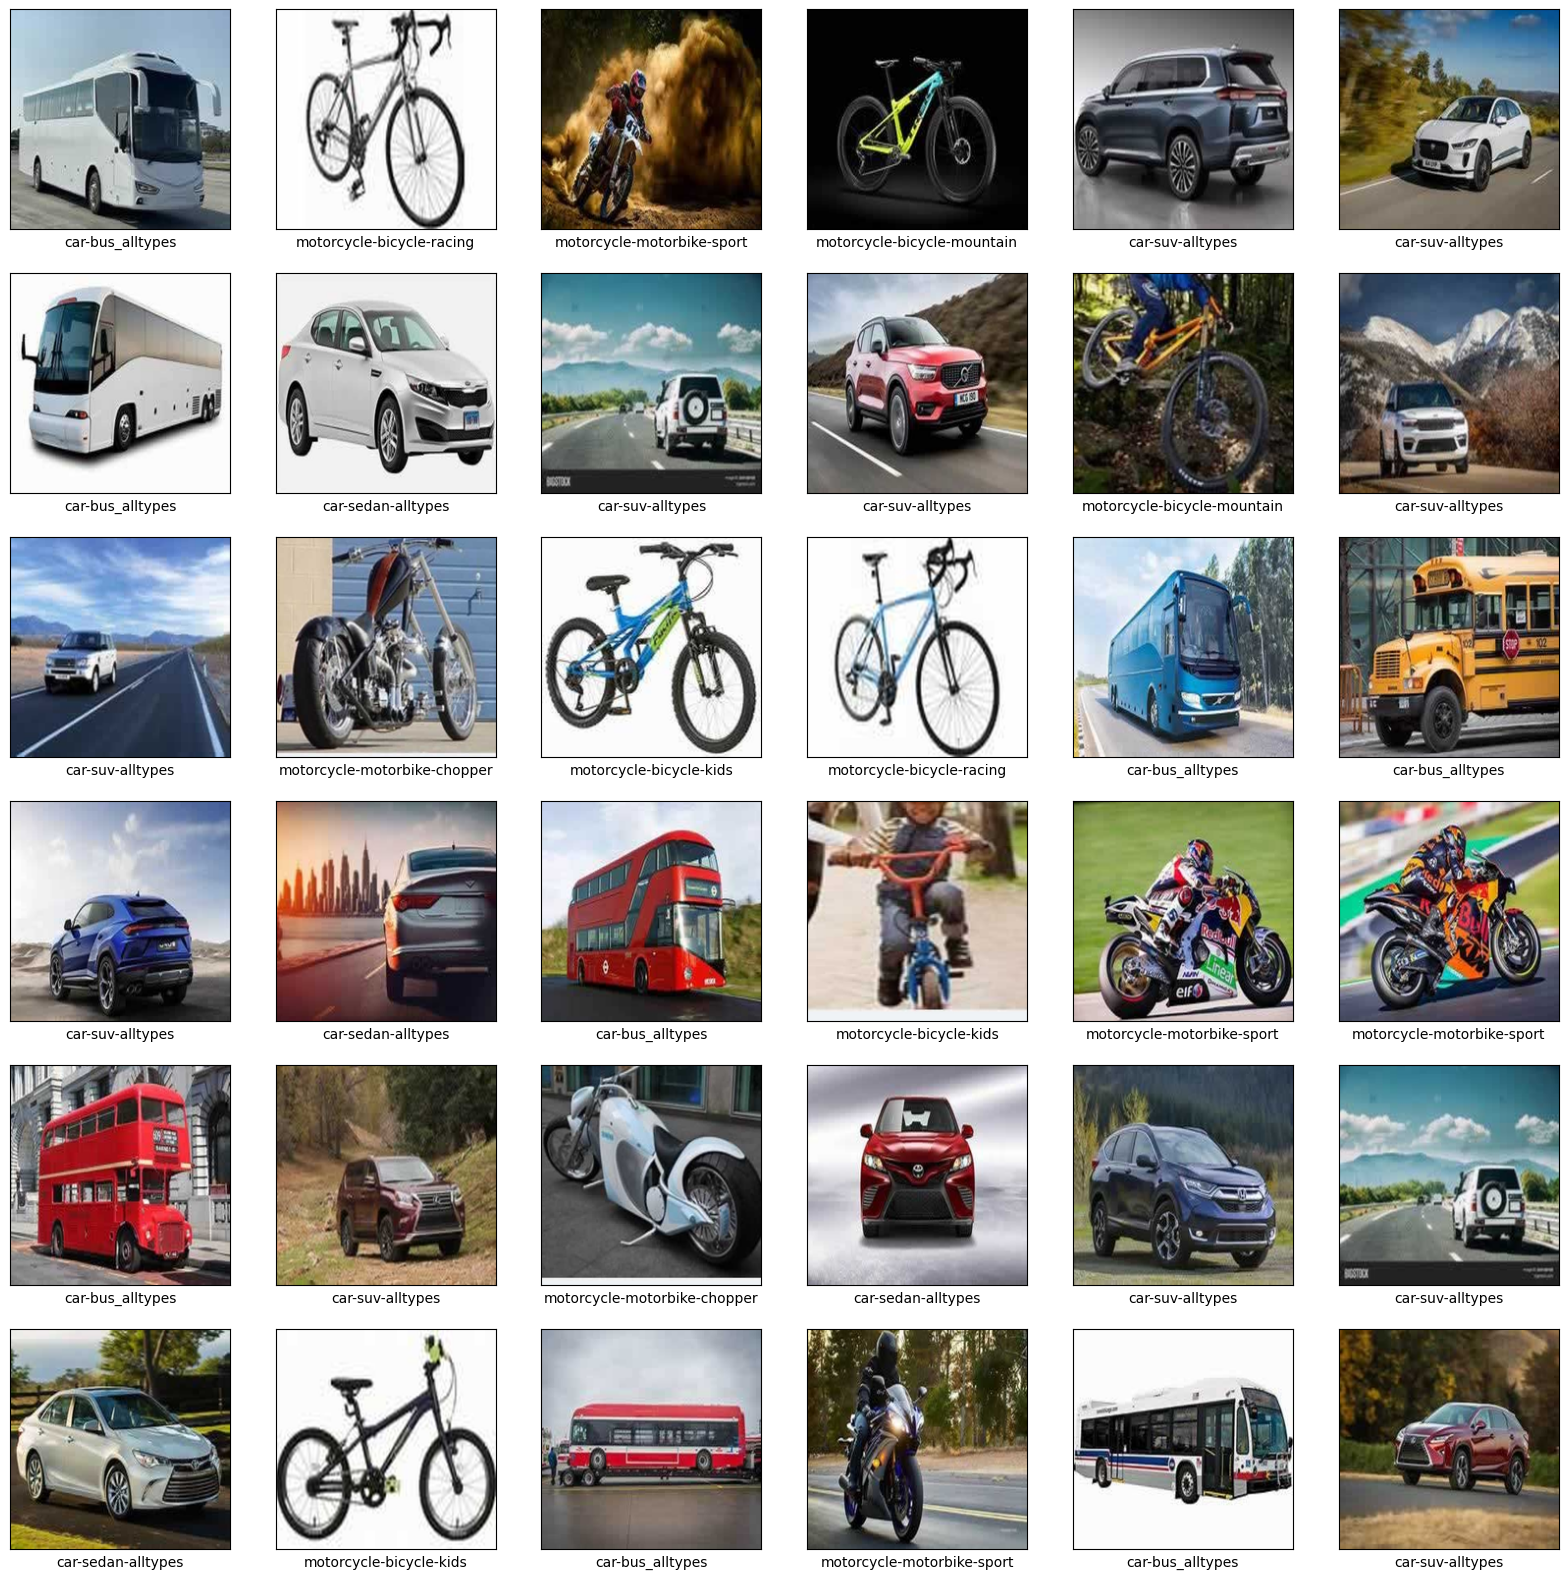

In [8]:
plot_sample_from_dataset(data, labels, rows=6, columns=6,width=20, height=20)

In [9]:
np.unique(labels)
number_of_classes = len(np.unique(labels))
number_of_classes

8

#### To display a single image


Label = motorcycle-motorbike-chopper
Image shape: (224, 224, 3)


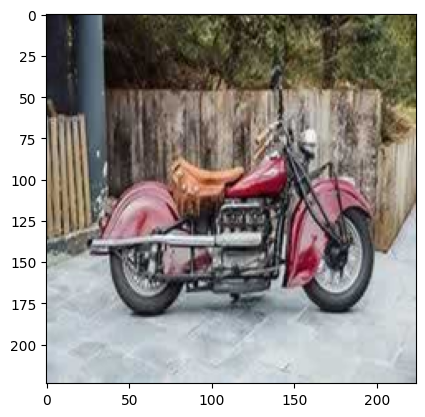

In [10]:
display_image(data, labels, index=100)

##### Data Shape verification

* It is important to understand the input to the neural network

##### Data Normalisation

* Convert pixel values from [0,255] to [0.0, 1.0] interval - 
* This helps making convergence of neural networks much faster 

* Convergence of a neural network is where the training of the model reaches a point where further training results in minimal changes to the model's parameters (weights and biases).  It means the model has learned to make predictions with an acceptable level of accuracy and the loss function (measure of difference between predicted and actual values) reaches a minimum or stops decreasing significantly.

* Normalisation scales the inputs to have similar magnitudes which helps in stabilising and speeding up training by stabilising gradient updates during back propagation (training).

In [11]:
#display shape
display_dataset_shape(data, labels)

#this function is in the utils_lib module - simply divide all values by 255
data_images = normalize_data(data)

Shape of images: (1362, 224, 224, 3)
Shape of labels: (1362,)
Normalizing data...


##### Binary Labels Creation (One-Hot Encoding)

![Automatic One-Hot-Encoding](../../images/one-hot-encode-Binarizer.png)

In [12]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

#perform one-hot encoding on the labels
print(f'labels: {labels[:10]}')
lb = LabelBinarizer() # create a binarizer object
binary_labels = lb.fit_transform(labels) # transform all labels into numpy array
print(f'Train_binary_labels after Binarizer: {binary_labels[:10]}')

labels: ['car-bus_alltypes' 'motorcycle-bicycle-racing'
 'motorcycle-motorbike-sport' 'motorcycle-bicycle-mountain'
 'car-suv-alltypes' 'car-suv-alltypes' 'car-bus_alltypes'
 'car-sedan-alltypes' 'car-suv-alltypes' 'car-suv-alltypes']
Train_binary_labels after Binarizer: [[1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]]


#### Convert the one-hot encoded vector into an integer value

In [13]:
#create a dictionary
import collections
car_dict ={}

for i,label in enumerate(binary_labels):
  car_dict[np.argmax(label)] = labels[i]
  #print(car_dict)
  if len(car_dict) == number_of_classes:
    break
print(car_dict)

{0: 'car-bus_alltypes', 5: 'motorcycle-bicycle-racing', 7: 'motorcycle-motorbike-sport', 4: 'motorcycle-bicycle-mountain', 2: 'car-suv-alltypes', 1: 'car-sedan-alltypes', 6: 'motorcycle-motorbike-chopper', 3: 'motorcycle-bicycle-kids'}


#### Create HDF5 Dataset

* Save the images, labels and binary labels into one HDF5 file
* ![HDF5 File Structure](../../images/HDF5%20File%20Structure.png)

* For this we need to have the following ready:
1. images in the numpy array format
2. Labels into string format
3. Binary labels that are one-hot encoded

In [14]:
import h5py
from pathlib import Path
#create the folder if it does not exist
Path(H5DATASET_FOLDER).mkdir(parents=True, exist_ok=True)

#ensure that the HDF5 file is not open
try:
  hf=h5py.File(TARGET_HDF5_DATASET_PATH, 'a')
  hf.close()
except OSError as e:
  print(f'Warning:{e}')
#open the HDF5 file
hf=h5py.File(TARGET_HDF5_DATASET_PATH, 'w')


images_shape = data.shape
labels_shape = labels.shape


In [15]:
#normalised images will be saved into the HDF5 file with the key "images"
hf.create_dataset("images", shape=images_shape,
                  maxshape=images_shape, 
                  compression='gzip',
                  compression_opts=9, 
                  data=data_images)

<HDF5 dataset "images": shape (1362, 224, 224, 3), type "<f8">

In [16]:
labels_in_ascii = [n.encode('unicode_escape') for n in labels]
#print(labels_in_ascii)

In [17]:
hf.create_dataset("labels",
                  shape=labels_shape,
                  compression="gzip",
                  compression_opts=9,
                  data = labels_in_ascii, dtype=class_label_string_length)

<HDF5 dataset "labels": shape (1362,), type "|S30">

#### Save the binary labels to the HDF5 file

In [18]:
hf.create_dataset("binary_labels",
                  shape=binary_labels.shape,
                  compression="gzip",
                  compression_opts=9,
                  data=binary_labels)

<HDF5 dataset "binary_labels": shape (1362, 8), type "<i4">

In [19]:
hf.close()

#### confirm the file is created by opening it in read mode

In [20]:
import h5py
hf = h5py.File(TARGET_HDF5_DATASET_PATH, "r")

labels_in_ascii = np.array(hf['labels']).astype(class_label_string_length)

print(f'Number of labels: {len(labels)}')

Number of labels: 1362


In [25]:
print(np.unique(labels))
hf.close()

['car-bus_alltypes' 'car-sedan-alltypes' 'car-suv-alltypes'
 'motorcycle-bicycle-kids' 'motorcycle-bicycle-mountain'
 'motorcycle-bicycle-racing' 'motorcycle-motorbike-chopper'
 'motorcycle-motorbike-sport']


#### Visualise Data Distribution

* It is important to understand how data is distributed in terms of images per class and resolution for each class
* This is because we need to make sure that the dataset is general enough to build a robust classifier
* Use the get_data_distribution() method in the utils_lib library

In [21]:
print(os.getcwd())
print(os.listdir("../../"))
sys.path.append("../../")  # Add the path to your module if necessary
from utils_lib import get_data_distribution

stats = get_data_distribution(DATASET_PATH, directory_depth=0, output_file=OUTPUT_STATS_FILE)

c:\coding_bootcamp\object-detection\vehicle-detection\vehicle-classification\deep-learning-project-Structure\02-prepare-dataset
['.git', '.gitignore', 'CreatingDataSets.md', 'dataset', 'deep-learning-project-Structure', 'h5-dataset', 'images', 'Other models', 'README.md', 'utils_lib.py', '__pycache__']
Loading images...
Stats collected and saved in . ../../h5-dataset/vehicle-type-dataset-SIZE224.hdf5.csv


#### Analyse the distribution visually

##### Key considerations
1. Image Size in KB: This generally indicates the file size. Differences in file sizes can arise from variations in resolution, compression, and image content.
2. Resolution and Aspect Ratio: These are critical factors. Ensure images are of similar resolution and aspect ratio to avoid resizing issues that could distort images and affect the training process.
3. Consistency: The images should be consistent in size to ensure the neural network can effectively learn from the dataset.

8  classes found in the dataset
Images of the whole dataset have an average size of  7.647709251101322
sizes of class [ dataset\car\car-bus\car-bus_alltypes ] have an average size of  8.178826086956521
sizes of class [ dataset\car\car-sedan\car-sedan-alltypes ] have an average size of  6.888574912891985
sizes of class [ dataset\car\car-suv\car-suv-alltypes ] have an average size of  6.908315254237288
sizes of class [ dataset\motorcycle\motorcycle-bicycle\motorcycle-bicycle-kids ] have an average size of  5.911811688311688
sizes of class [ dataset\motorcycle\motorcycle-bicycle\motorcycle-bicycle-mountain ] have an average size of  7.763307692307692
sizes of class [ dataset\motorcycle\motorcycle-bicycle\motorcycle-bicycle-racing ] have an average size of  7.5784102564102565
sizes of class [ dataset\motorcycle\motorcycle-motorbike\motorcycle-motorbike-chopper ] have an average size of  14.599409638554219
sizes of class [ dataset\motorcycle\motorcycle-motorbike\motorcycle-motorbike-sport ]

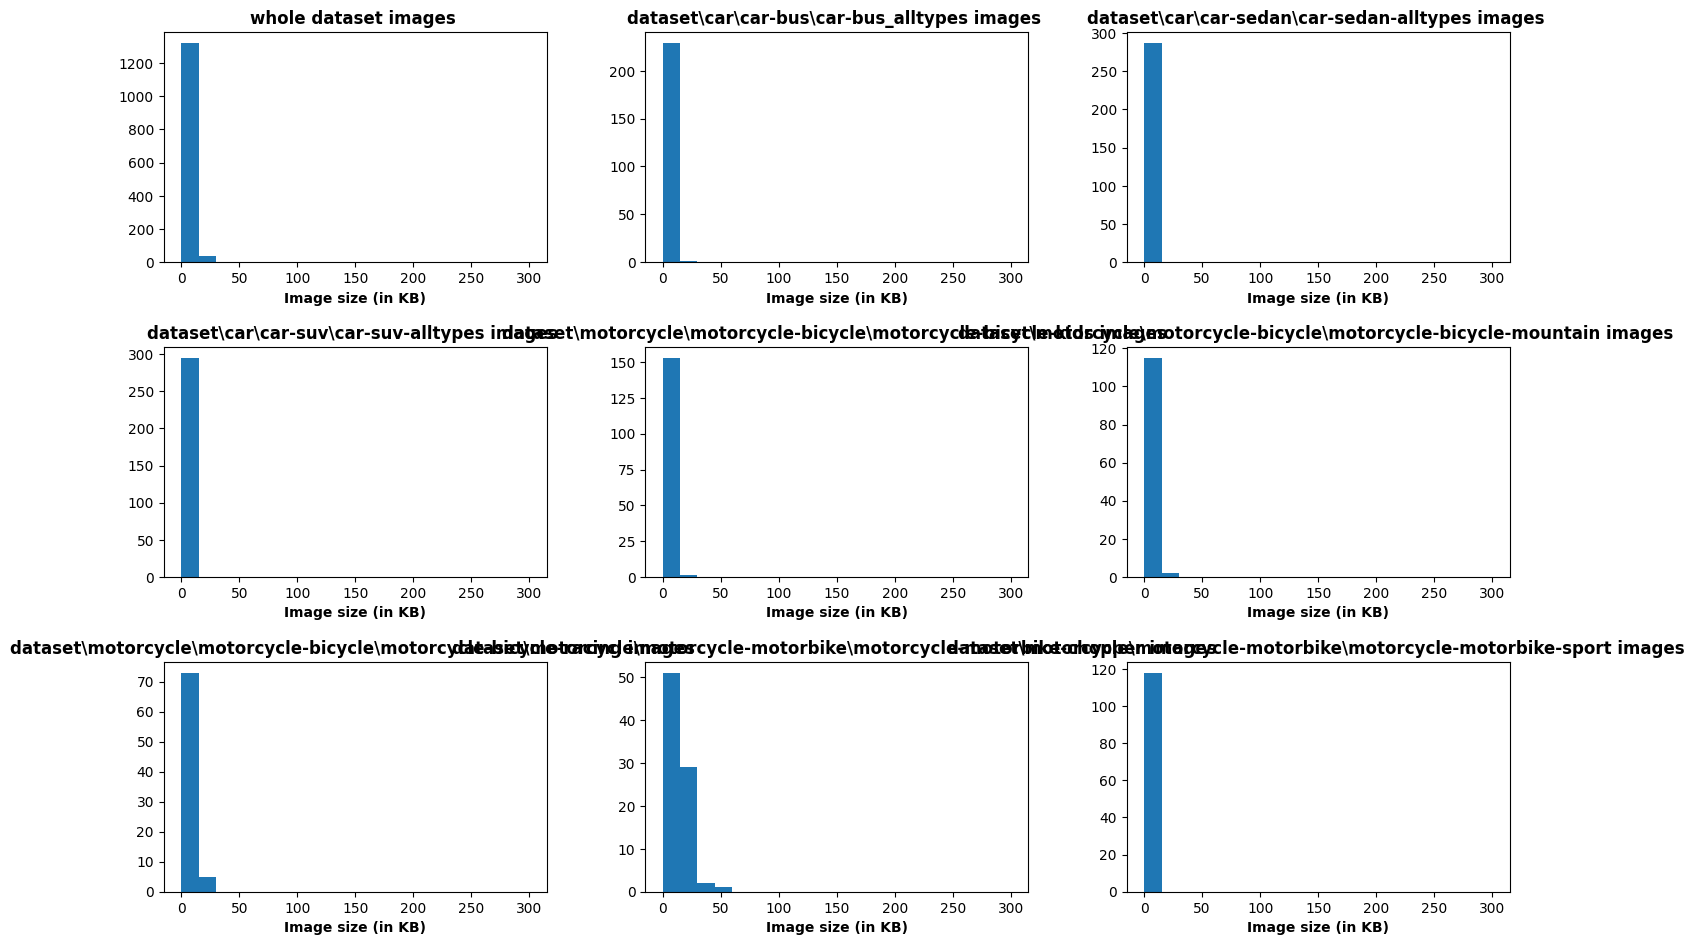

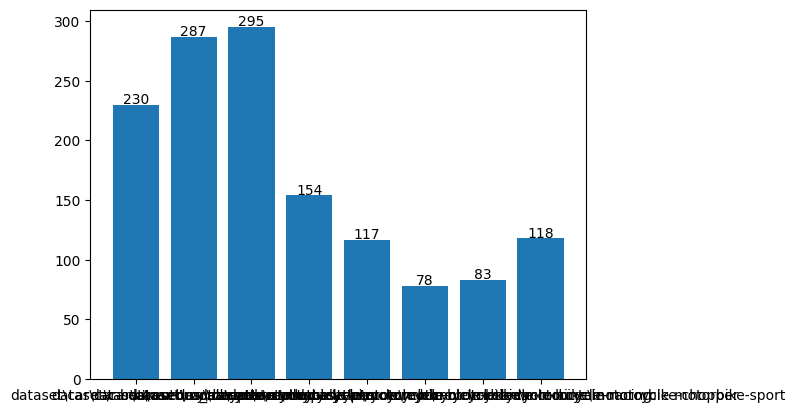

In [22]:
plot_dataset_distribution(stats, num_cols=3, width=15, height=10, histogram_bins = 20, histogram_range=[0, 300], figure_padding=4)

Dataset is not very balanced - we need to balance the dataset